In [22]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Elaborazione immagini: 100%|██████████| 8492/8492 [00:04<00:00, 1757.47it/s]


(8476, 4096)
(8476,)


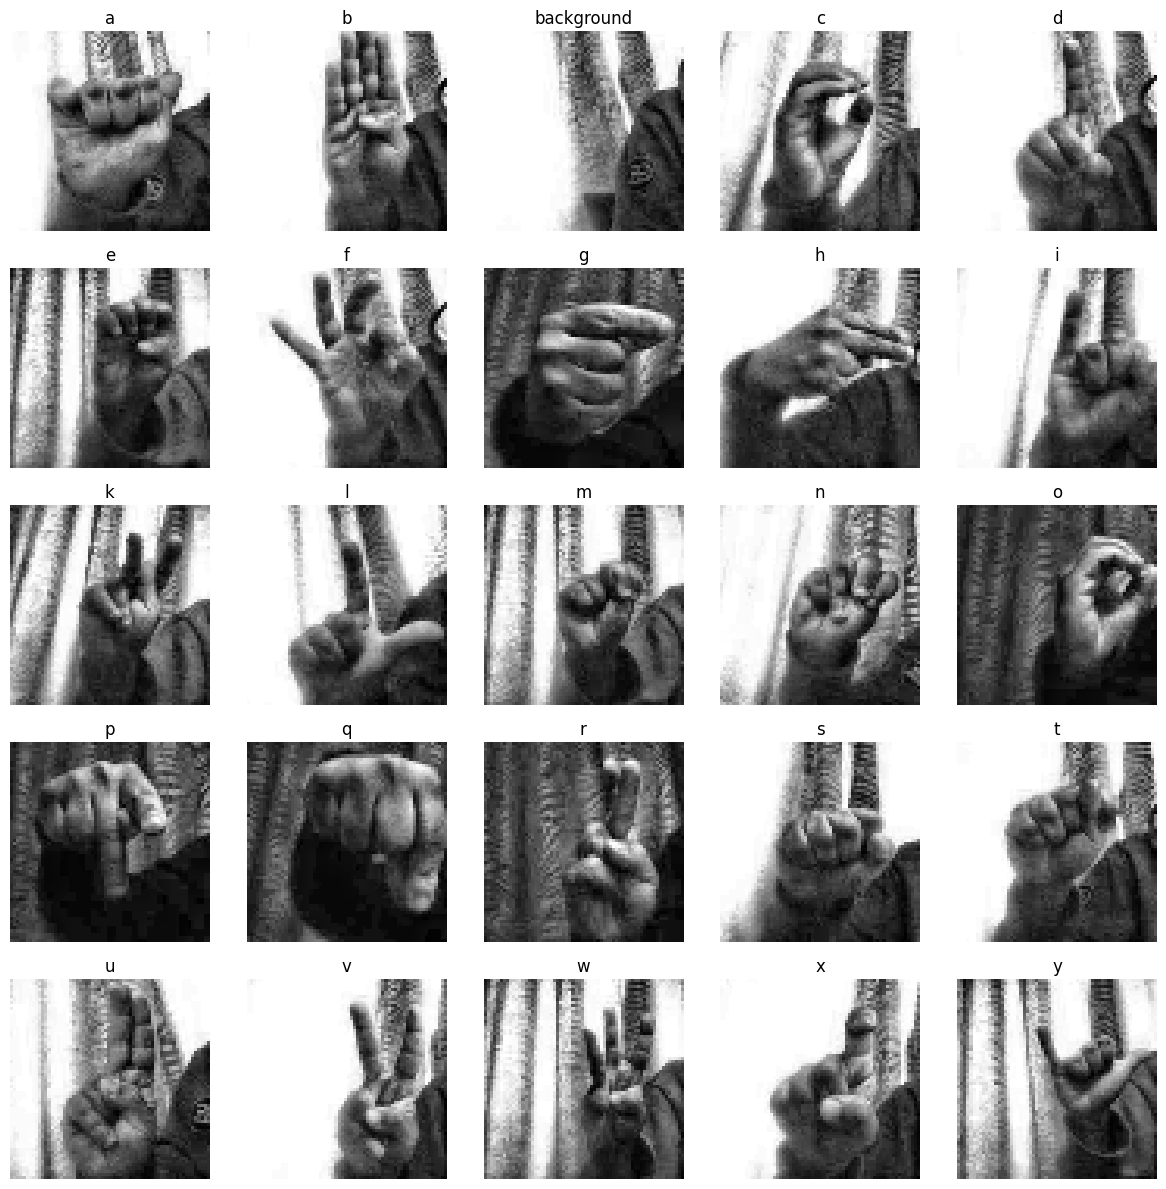

In [23]:
def load_from_filenames(folder_path, img_size=64):
    features_list = []
    labels_list = []

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    # Lista tutti i file nella cartella
    all_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    for filename in tqdm(all_files, desc="Elaborazione immagini"):
        # 1. Estrazione Label: prendiamo tutto ciò che sta prima del primo '_'
        # Esempio: "background_a_1.png" -> "background"
        # Esempio: "a_v1.png" -> "a"
        label = filename.split('_')[0]
        
        # 2. Caricamento e Preprocessing
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
            
        img = cv2.resize(img, (img_size, img_size))
        feat = clahe.apply(img)/255 # Bilancia l'esposizione
        
        features_list.append(feat.flatten())
        labels_list.append(label)
        
    return np.array(features_list), np.array(labels_list)


X, y = load_from_filenames("/home/mattia/Desktop/unige/ml2/machineLearning2_Assignment/training-a-robot-to-understand-sign-language/signlanguage/signlanguage")

# Utilizzo:
print(X.shape)
print(y.shape)

sorted_indices = np.argsort(y)

# Applica l'ordinamento sia a X che a y
X_sorted = X[sorted_indices]
y_sorted = y[sorted_indices]
# --------------------------------

unique_labels, first_indices = np.unique(y_sorted, return_index=True)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))
axs = axs.flatten()

for i, idx in enumerate(first_indices):
    if i < len(axs):
        imm = X_sorted[idx].reshape(64, 64)
        axs[i].imshow(imm, cmap='gray')
        axs[i].set_title(f"{y_sorted[idx]}")
        axs[i].axis('off')

# Nascondi i subplot vuoti se le classi sono meno di 25
for j in range(len(unique_labels), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

Xl, Xt, yl, yt = train_test_split(X, y, test_size=0.75, random_state=11)

In [24]:
from sklearn.svm import LinearSVC

# Griglia per LinearSVC (usa 'C' come SVC, ma è molto più rapido)
grid = {'C': np.logspace(-6, 3, 10)}

M = GridSearchCV(estimator  = LinearSVC(dual=False), # dual=False è meglio quando n_samples > n_features
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'balanced_accuracy',
                 n_jobs     = 20)

M.fit(Xl, yl)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.tree import plot_tree

def quality(M,XT,YT):
  Yp = M.predict(XT)
  print('ACC: ' + format(accuracy_score(YT,Yp),".3f"))
  print('BAC: ' + format(balanced_accuracy_score(YT,Yp),".3f"))
  print('CM: \n' + str(confusion_matrix(YT,Yp)))
quality(M,Xt,yt)
# Ora coef_ sarà (25, 4096)
best_model = M.best_estimator_
weights = best_model.coef_ 
print(f"Forma dei coefficienti: {weights.shape}") # Output atteso: (25, 4096)

ACC: 0.909
BAC: 0.913
CM: 
[[237   1   1   3   2   0   5   0   0   3   4   0   3   9   0   0   0   0
    0   1   2   0   0   0   6]
 [  4 337   1   4   3   5   6   0   0   0   4   0   0   0   0   1   0   0
    1   0   0   0   0   4   0]
 [  0   0 355   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   1   0 255   4   0   3   0   1   1   1   0   1   0   2   0   0   0
    1   0   0   0   8   1   0]
 [  0   2   0   0 181   1   1   1   0   5   1   0  10   1   5   1   0   0
    0   0   3   0   0   1   2]
 [  6   0   0   0   0 183   0   0   0   0   0   0   1   1   5   0   0   0
    0   2   0   0   0   0   0]
 [  1   3   0   5   0   3 226   0   0   2   0   0   0   0   3   0   0   1
    0   0   0   1   0   1   0]
 [  0   0   0   0   0   0   0 217   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  4   0   0   0   0   1   0   9 253   2   0   0   0   0   0   3   1   0
    0   0   0   0   0   2   0]
 [  1   0   2   0   9   0   

Classe a: Sparsity = 0.24%
Classe b: Sparsity = 0.49%
Classe background: Sparsity = 0.46%
Classe c: Sparsity = 0.42%
Classe d: Sparsity = 0.44%
Classe e: Sparsity = 0.54%
Classe f: Sparsity = 0.44%
Classe g: Sparsity = 0.49%
Classe h: Sparsity = 0.83%
Classe i: Sparsity = 0.44%
Classe k: Sparsity = 0.22%
Classe l: Sparsity = 0.76%
Classe m: Sparsity = 0.24%
Classe n: Sparsity = 0.17%
Classe o: Sparsity = 0.34%
Classe p: Sparsity = 0.68%
Classe q: Sparsity = 0.66%
Classe r: Sparsity = 0.44%
Classe s: Sparsity = 0.66%
Classe t: Sparsity = 0.44%
Classe u: Sparsity = 0.32%
Classe v: Sparsity = 0.32%
Classe w: Sparsity = 0.22%
Classe x: Sparsity = 0.27%
Classe y: Sparsity = 0.42%


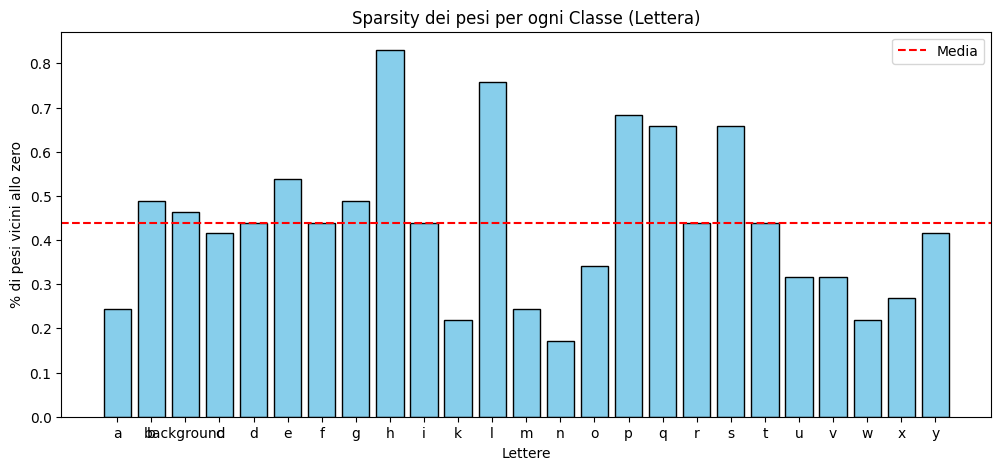

In [27]:
# Soglia di tolleranza: i pesi più piccoli di questa sono considerati "sparsi"
threshold = 1e-4

# Per ogni classe (riga di w), calcoliamo la % di elementi sotto soglia
for i, class_name in enumerate(best_model.classes_):
    n_zero = np.sum(np.abs(weights[i]) < threshold)
    sparsity = (n_zero / weights.shape[1]) * 100
    print(f"Classe {class_name}: Sparsity = {sparsity:.2f}%")

sparsity_list = [np.mean(np.abs(weights[i]) < threshold) * 100 for i in range(len(weights))]

plt.figure(figsize=(12, 5))
plt.bar(best_model.classes_, sparsity_list, color='skyblue', edgecolor='black')
plt.axhline(y=np.mean(sparsity_list), color='r', linestyle='--', label='Media')

plt.title("Sparsity dei pesi per ogni Classe (Lettera)")
plt.ylabel("% di pesi vicini allo zero")
plt.xlabel("Lettere")
plt.legend()
plt.show()

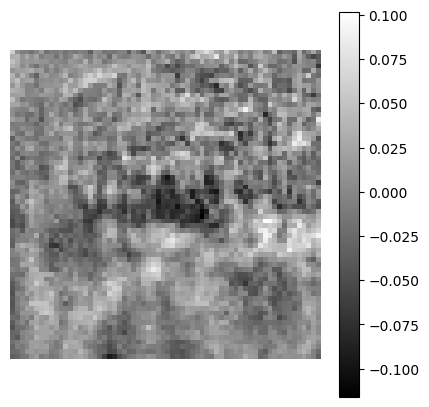

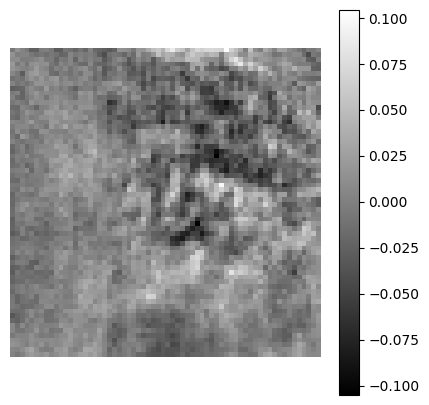

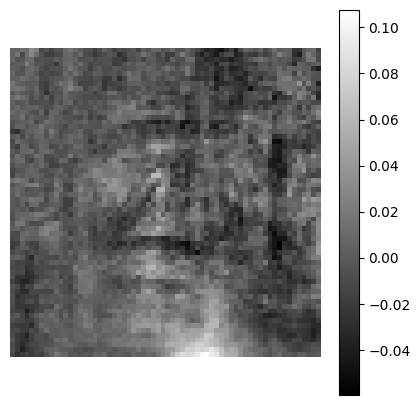

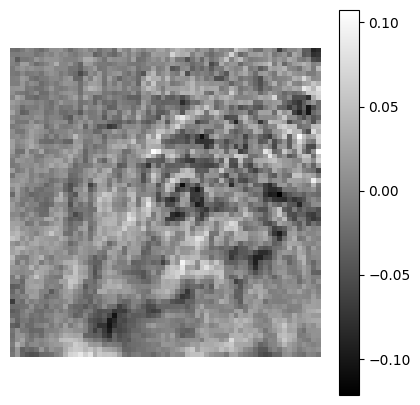

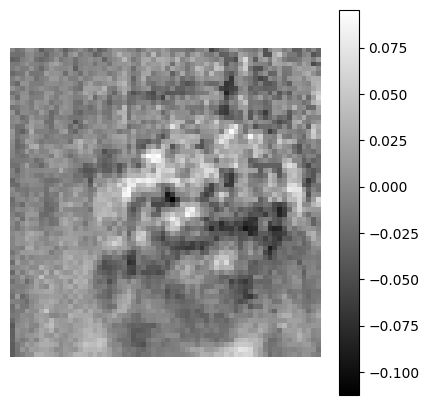

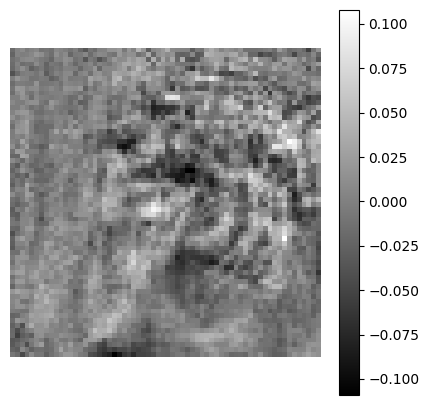

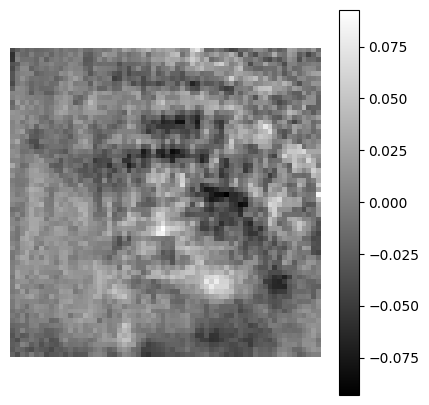

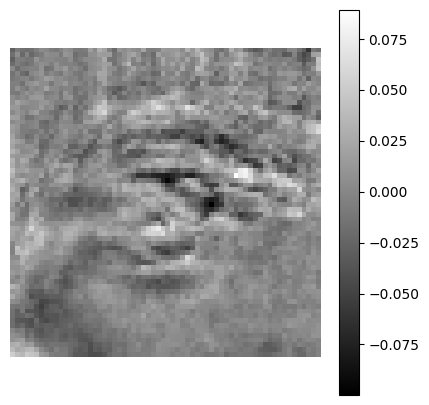

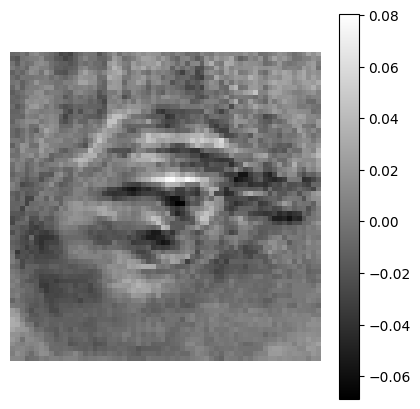

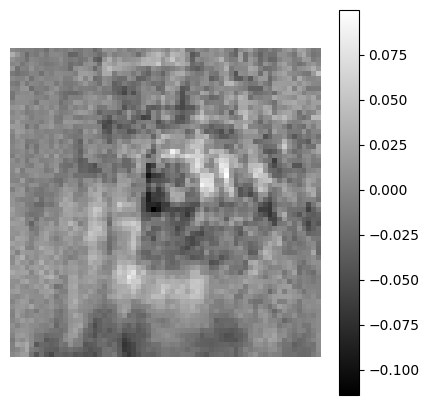

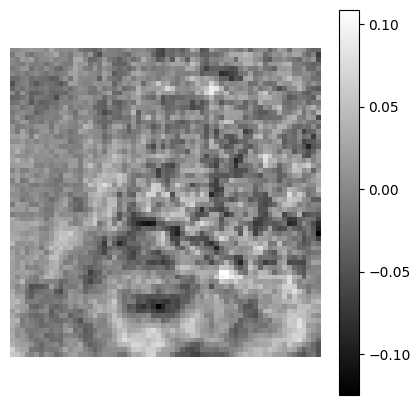

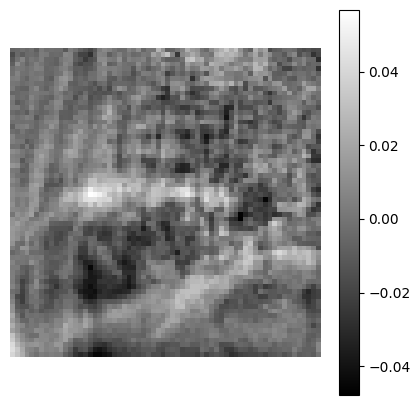

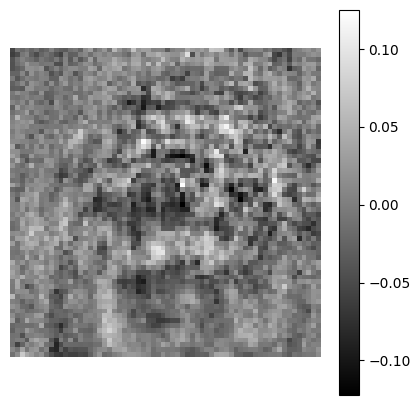

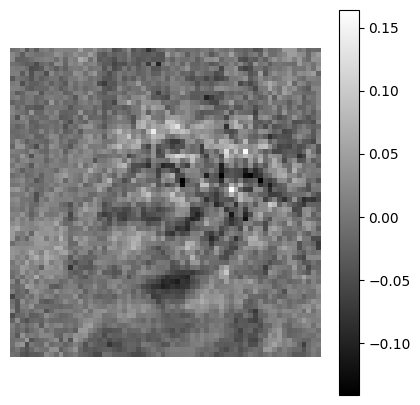

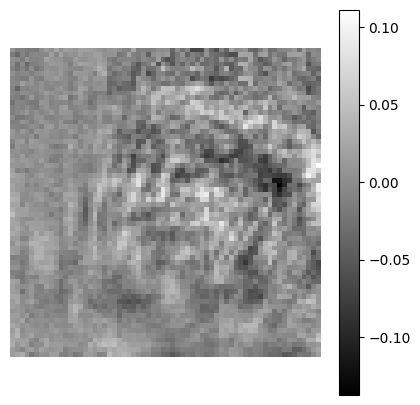

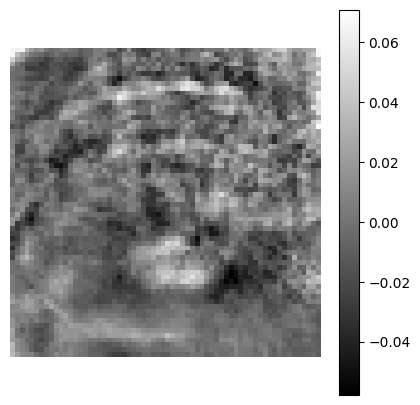

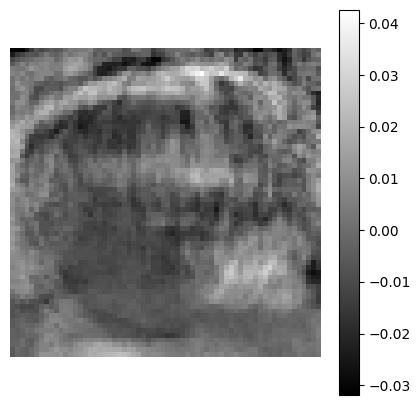

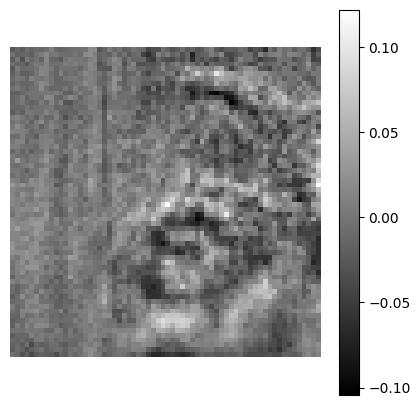

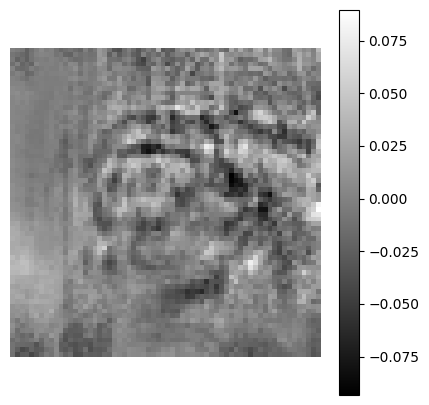

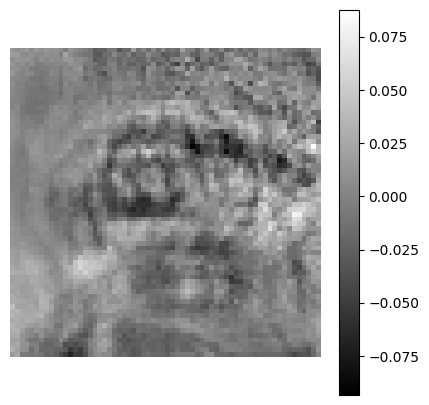

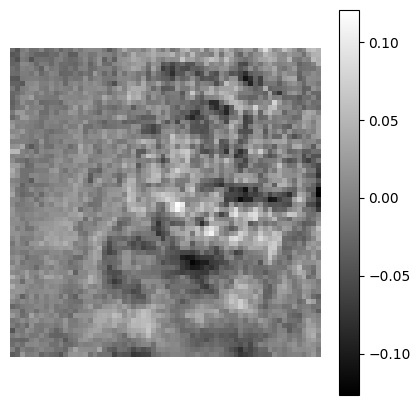

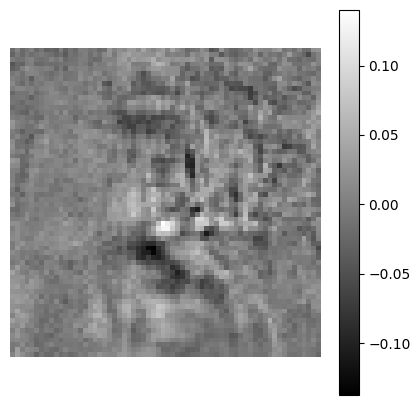

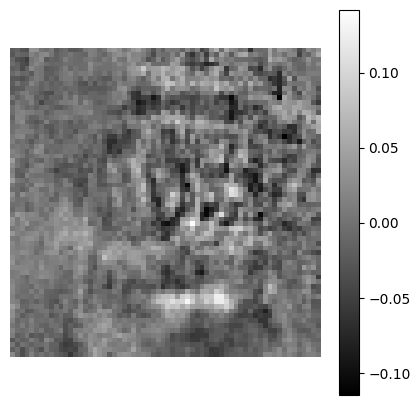

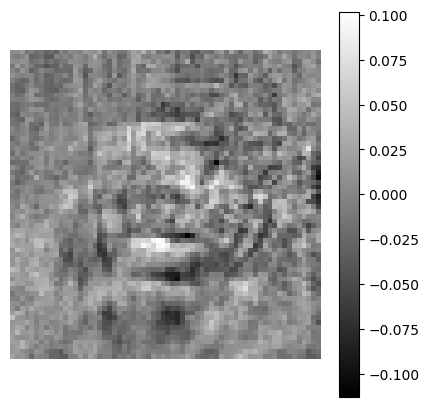

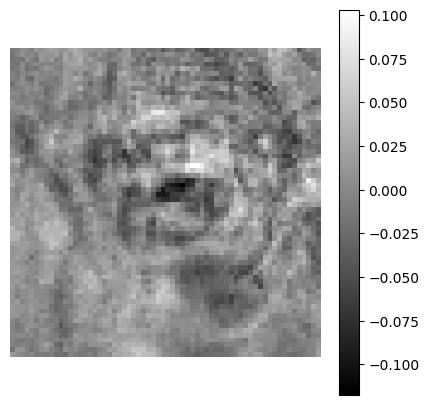

In [26]:
import matplotlib.pyplot as plt

w_best = M.best_estimator_
w = w_best.coef_
for i in range(len(w)):
    model = np.reshape(w[i],(64,64))
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(model, cmap='gray')
    ax.axis('off')
    fig.colorbar(im)
    plt.show()
